In [55]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S1

In [56]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [57]:
import importlib

## Preprocessing
### Read data

In [58]:
data_path = "../../data/MOBA_scRNAseq/outs_S1"

data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")


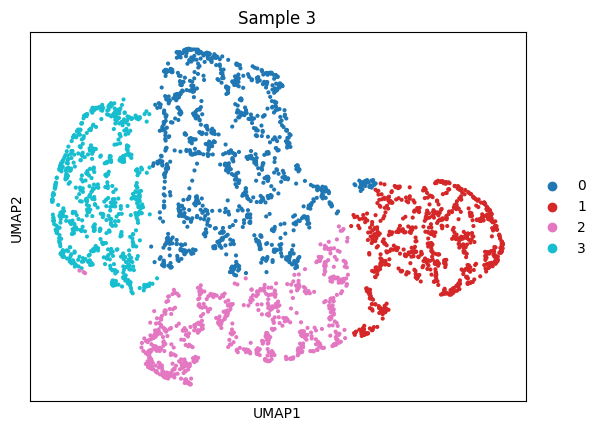

In [59]:
# sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Initial DE testing: Wilcoxon rank-sum for every cluster against all others

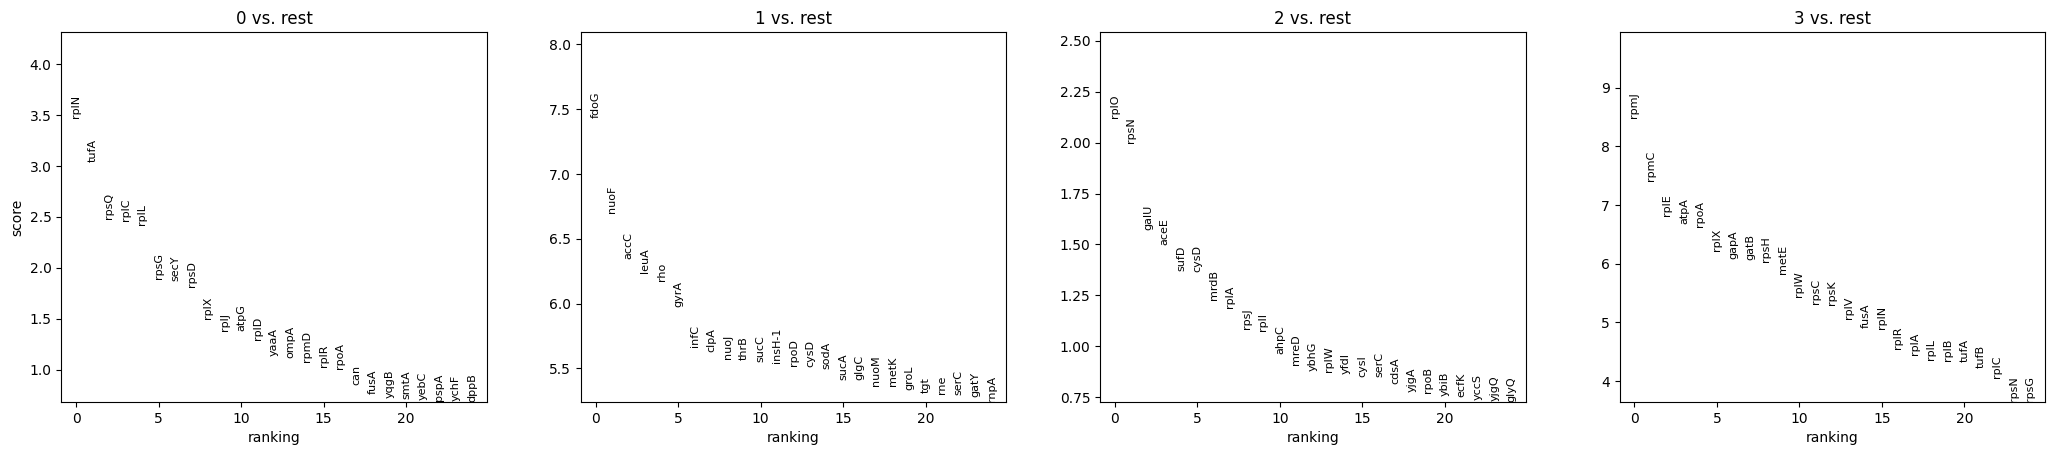

In [60]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [61]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
gene 200
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
gene 500
Both NB and ZINB not converged! Using NB without starting params
gene 600
gene 700
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 800
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 900
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
ge

## Find optimal correlation matrix scaling and generate synthetic null data

In [62]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 0.0
Factor: 2 - Error: 0.0
Factor: 3.6180339999999998 - Error: 0.0
1


In [63]:
# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [64]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [65]:
data_null_gen.var_names

Index(['aaeA', 'aaeB', 'aaeR', 'aaeX', 'aas', 'aat', 'abgA', 'abgB', 'abgR',
       'abgT',
       ...
       'zntR', 'znuA', 'znuB', 'znuC', 'zraP', 'zraR', 'zraS', 'zupT', 'zur',
       'zwf'],
      dtype='object', name='index', length=3955)

In [66]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [67]:
data_null_gen.var

,var_counts,mean_counts
index,,
aaeA,0.002945,0.002953
aaeB,0.001474,0.001477
aaeR,0.012140,0.010780
aaeX,0.001622,0.001624
aas,0.025358,0.022002
...,...,...
zraR,0.007915,0.007679
zraS,0.003971,0.003987
zupT,0.014901,0.012699


In [68]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

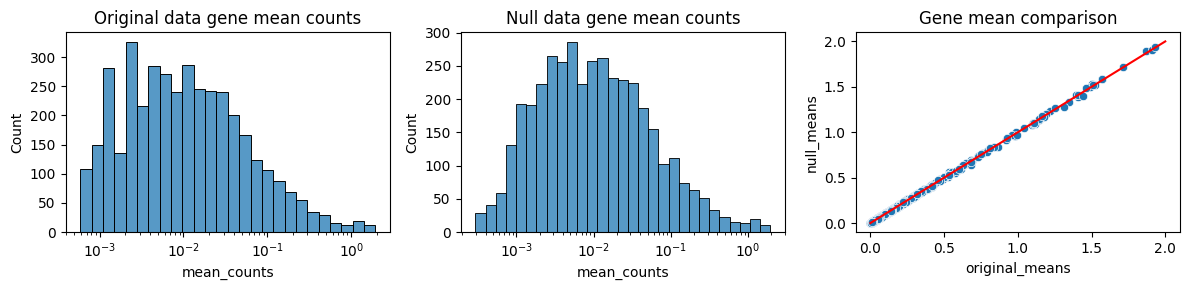

SignificanceResult(statistic=0.9916253656053245, pvalue=0.0)


In [69]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

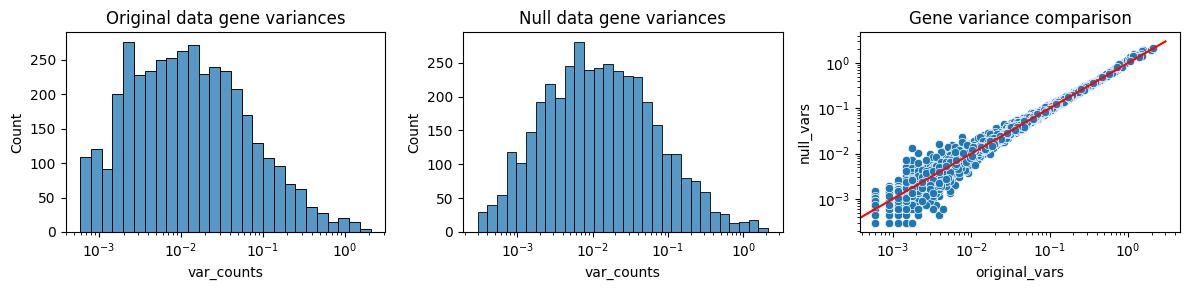

SignificanceResult(statistic=0.9855922352805168, pvalue=0.0)
[[1.         0.99619894]
 [0.99619894 1.        ]]


In [70]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

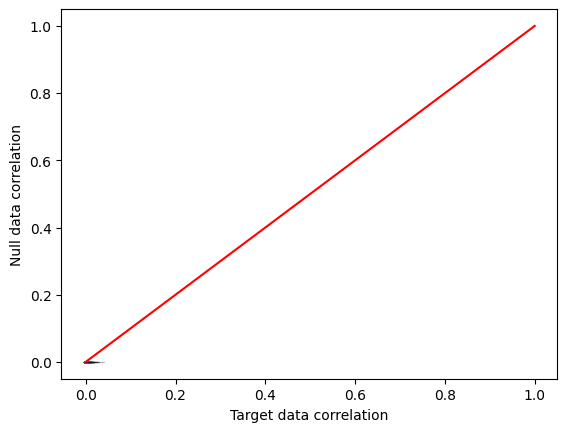

In [71]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [72]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [73]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", seed=1234)
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


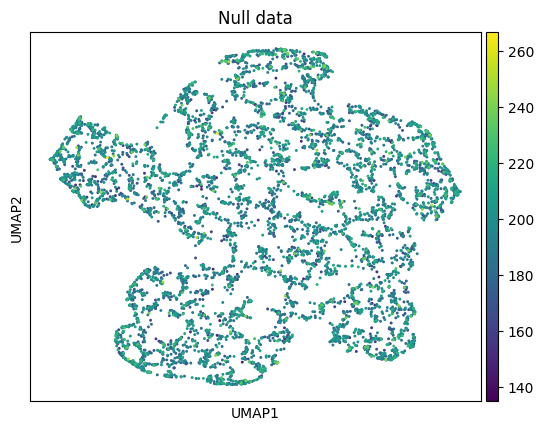

In [74]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [75]:
data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [76]:
n_splits = 1
rng = np.random.default_rng(1234)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    was_greater = False
    max_res_1_cluster = 0.01
    
    while twoclust is False:
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        print(f"resolution: {res2}, clusters: {nclust}")

        if nclust == 2:
            twoclust = True
            break
        elif nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            else: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 5*res_step
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 5)

            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 5*res_step
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}")

resolution: 0.01, clusters: 1
resolution: 0.035, clusters: 2
split 1/1 - Resolution 0.035
Best split: No. 0 - seed: 979 - minimal p-value: 1.1218790535624631e-08


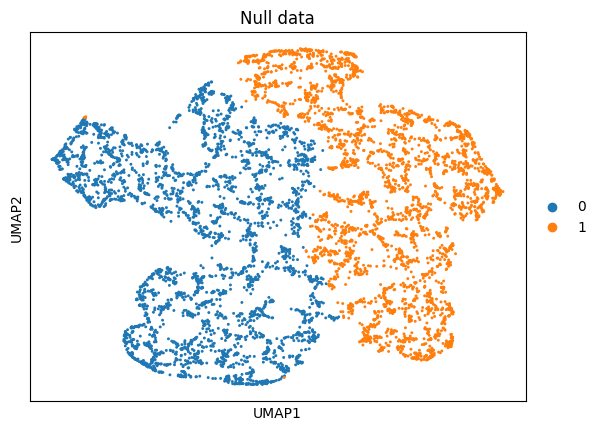

In [77]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [78]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [82]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 2 - DE genes: 0; Minimum q value: 1.0
Cluster 3 - DE genes: 0; Minimum q value: 0.05555555555555555
Cluster 1 - DE genes: 1423; Minimum q value: 0.0064516129032258064
Cluster 0 - DE genes: 0; Minimum q value: 0.4166666666666667


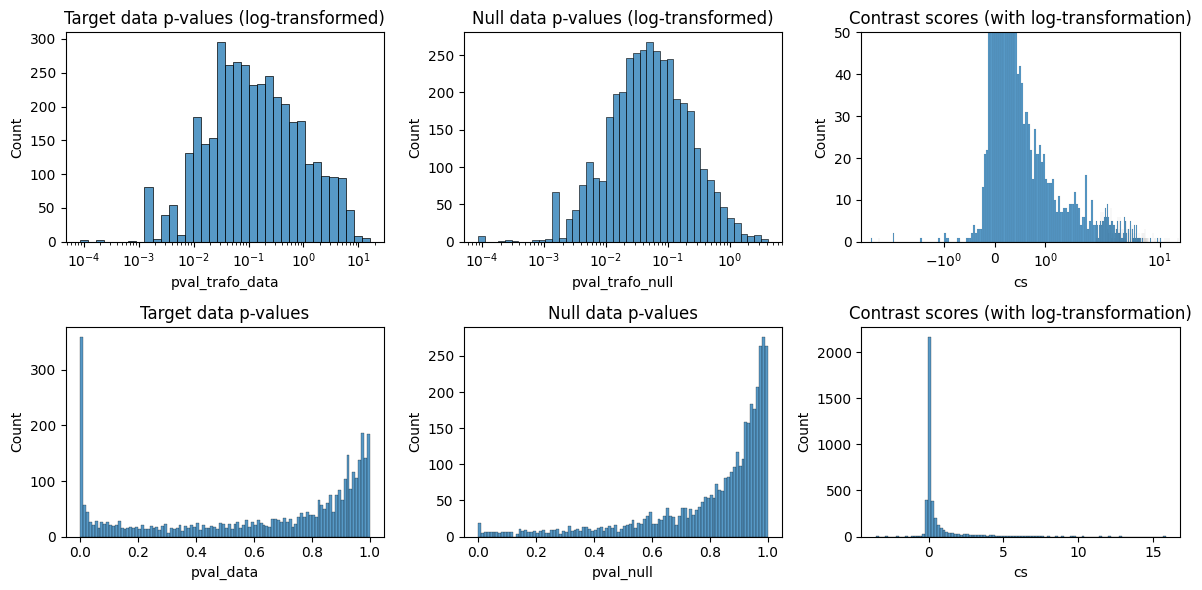

In [83]:
c = "1"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [84]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 2
1.0    3955
Name: q, dtype: int64

cluster 3
0.055556      18
0.068493      55
0.070423      69
0.072626      37
0.077348       2
            ... 
0.710962       1
0.711161       5
0.711700      25
0.713404       3
1.000000    1687
Name: q, Length: 478, dtype: int64

cluster 1
0.006452     155
0.009615      53
0.009709     101
0.012346      96
0.012371      80
            ... 
0.326975       1
0.327886       1
0.327891       3
0.328242       6
1.000000    1009
Name: q, Length: 504, dtype: int64

cluster 0
0.416667      36
0.435897       3
0.450000       1
0.463415       1
0.465116       2
            ... 
0.991655       2
0.993103       6
0.994490       1
0.998630       4
1.000000    3225
Name: q, Length: 117, dtype: int64



In [85]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
index,,,,,,
rplA,0.000010,0.957919,4.985522,0.018671,4.966851,0.416667
aceE,0.000928,0.907652,3.032593,0.042081,2.990512,0.416667
atpF,0.001001,0.864794,2.999543,0.063087,2.936455,0.416667
leuA,0.001442,0.596617,2.841101,0.224304,2.616797,0.416667
nuoN,0.002901,0.890310,2.537425,0.050459,2.486967,0.416667
...,...,...,...,...,...,...
pntA,0.678576,0.000574,0.168401,3.241290,-3.072889,1.000000
cyoD,0.345592,0.000240,0.461437,3.620519,-3.159083,1.000000
rplP,0.998350,0.000282,0.000717,3.549666,-3.548949,1.000000


In [86]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [87]:
data_gene_nonzero.write(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")

In [88]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,Protein accession,Name,Symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
index,,,,,,,,,,,,,,,,,,,,,
aaeA,Gene Expression,PA01,9,0.002953,0.002949,99.734200,10.0,2.397895,9,0.003535,...,NP_417708.1,aromatic carboxylic acid efflux pump membrane ...,aaeA,0.002953,0.003535,-5.819453e-04,nb,0.002953,0.014765,0.000000
aaeB,Gene Expression,PA01,2,0.000591,0.000590,99.940933,2.0,1.098612,2,0.000590,...,NP_417707.1,aromatic carboxylic acid efflux pump subunit AaeB,aaeB,0.000591,0.000590,3.488880e-07,poi,0.003494,inf,0.828815
aaeR,Gene Expression,PA01,31,0.010041,0.009991,99.084465,34.0,3.555348,31,0.011713,...,NP_417710.1,DNA-binding transcriptional activator AaeR,aaeR,0.010041,0.011713,-1.671174e-03,nb,0.010031,0.052576,0.000000
aaeX,Gene Expression,PA01,7,0.002363,0.002360,99.793266,8.0,2.197225,7,0.002948,...,NP_417709.2,DUF1656 domain-containing protein AaeX,aaeX,0.002363,0.002948,-5.850852e-04,nb,0.002362,0.007920,0.000000
aas,Gene Expression,PA01,63,0.020969,0.020752,98.139398,71.0,4.276666,63,0.025254,...,NP_417313.1,fused 2-acylglycerophospho-ethanolamine acyltr...,aas,0.020969,0.025254,-4.285653e-03,nb,0.020971,0.087359,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zraR,Gene Expression,PA01,27,0.008565,0.008528,99.202599,29.0,3.401197,27,0.009673,...,NP_418432.1,DNA-binding transcriptional activator ZraR,zraR,0.008565,0.009673,-1.107981e-03,nb,0.008565,0.067938,0.000000
zraS,Gene Expression,PA01,13,0.003839,0.003832,99.616066,13.0,2.639057,13,0.003825,...,NP_418431.1,sensor histidine kinase ZraS,zraS,0.003839,0.003825,1.474052e-05,poi,0.004799,inf,0.199960
zupT,Gene Expression,PA01,42,0.014471,0.014368,98.759598,49.0,3.912023,42,0.018397,...,NP_417512.1,divalent metal ion transporter ZupT,zupT,0.014471,0.018397,-3.925252e-03,nb,0.014473,0.042861,0.000000


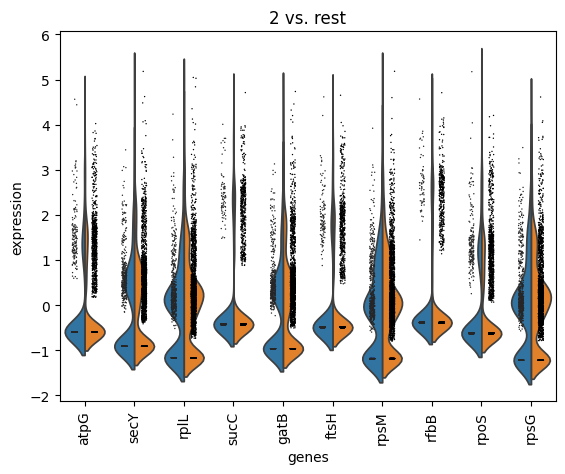

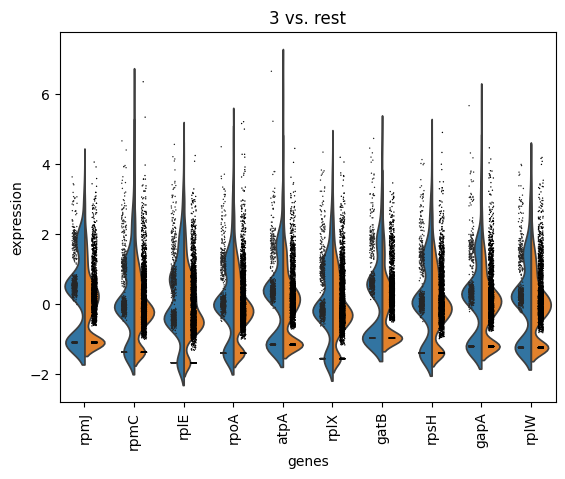

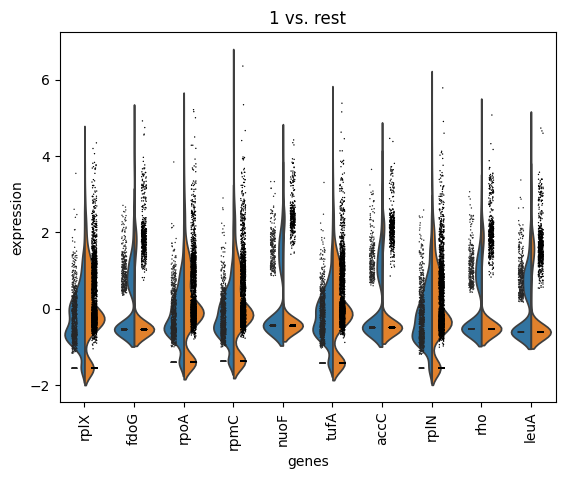

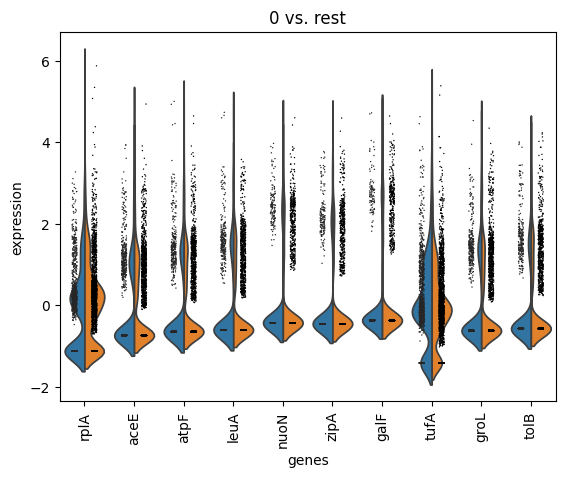

In [89]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [90]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["Locus tag", "Name", "Symbol"]])

Cluster 2
      Locus tag                                          Name Symbol
index                                                               
atpG      b3733         ATP synthase F1 complex subunit gamma   atpG
secY      b3300                   Sec translocon subunit SecY   secY
rplL      b3986             50S ribosomal subunit protein L12   rplL
sucC      b0728          succinyl-CoA synthetase subunit beta   sucC
gatB      b2093  galactitol-specific PTS enzyme IIB component   gatB
ftsH      b3178       ATP-dependent zinc metalloprotease FtsH   ftsH
rpsM      b3298             30S ribosomal subunit protein S13   rpsM
rfbB      b2041                dTDP-glucose 4,6-dehydratase 1   rfbB
rpoS      b2741              RNA polymerase sigma factor RpoS   rpoS
rpsG      b3341              30S ribosomal subunit protein S7   rpsG
Cluster 3
      Locus tag                                          Name Symbol
index                                                               
rpmJ      b329

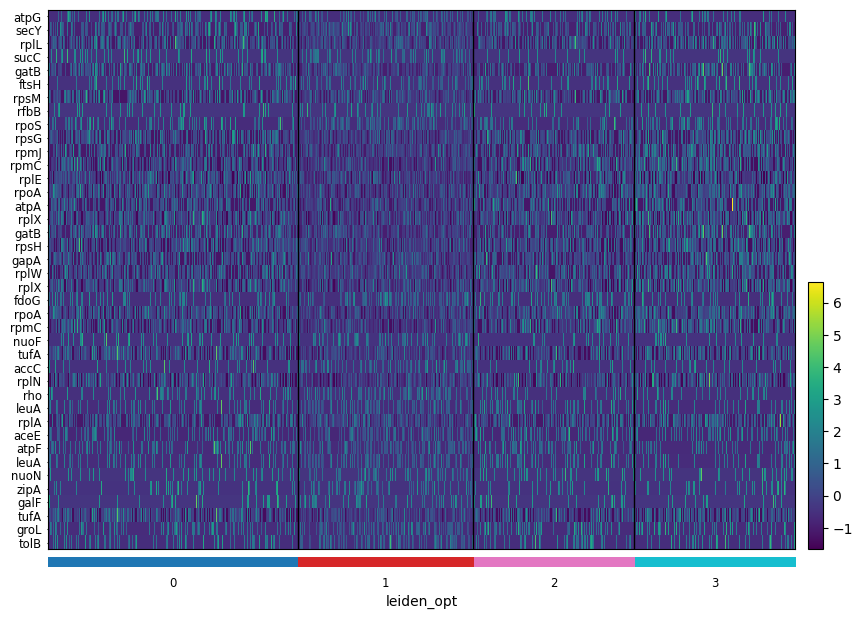

In [91]:
sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True)